# 메모리 네트워크를 사용해 에피소드 데이터에 대한 질의 응답

In [ ]:
import keras
import tensorflow
print(keras.__version__, tensorflow.__version__)

In [1]:
from __future__ import division, print_function

import collections
import itertools
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [2]:
def get_data(infile):
    stories, questions, answers = [], [], []
    story_text = []
    fin = open(Train_File, "rb")
    for line in fin:
        line = line.decode("utf-8").strip()
        lno, text = line.split(" ", 1)
        if "\t" in text:
            question, answer, _ = text.split("\t")
            stories.append(story_text)
            questions.append(question)
            answers.append(answer)
            story_text = []
        else:
            story_text.append(text)
    fin.close()
    return stories, questions, answers

In [3]:
file_location = "./"
Train_File = os.path.join(file_location, "qa1_single-supporting-fact_train.txt")
Test_File = os.path.join(file_location, "qa1_single-supporting-fact_test.txt")

# 데이터 가져오기
data_train = get_data(Train_File)
data_test = get_data(Test_File)

print("\n\nTrain observations:",len(data_train[0]),"Test observations:", len(data_test[0]),"\n\n")



Train observations: 10000 Test observations: 10000 




In [4]:
# 학습 및 테스트 데이터에서 Vocab 딕셔너리 구축
dictnry = collections.Counter()
for stories,questions,answers in [data_train,data_test]:
    for story in stories:
        for sent in story:
            for word in nltk.word_tokenize(sent):
                dictnry[word.lower()] +=1
    for question in questions:
        for word in nltk.word_tokenize(question):
            dictnry[word.lower()]+=1
    for answer in answers:
        for word in nltk.word_tokenize(answer):
            dictnry[word.lower()]+=1
                
word2indx = {w:(i+1) for i,(w,_) in enumerate(dictnry.most_common())}

word2indx["PAD"] = 0
indx2word = {v:k for k,v in word2indx.items()}

vocab_size = len(word2indx)
print("vocabulary size:",len(word2indx))

vocabulary size: 22


In [5]:
# 각 엔티티의 최대 시퀀스 길이 계산
story_maxlen = 0
question_maxlen = 0
for stories, questions, answers in [data_train,data_test]:
    for story in stories:
        story_len = 0
        for sent in story:
            swords = nltk.word_tokenize(sent)
            story_len += len(swords)
        if story_len > story_maxlen:
            story_maxlen = story_len
    for question in questions:
        question_len = len(nltk.word_tokenize(question))
        if question_len > question_maxlen:
            question_maxlen = question_len
            
print ("Story maximum length:",story_maxlen,"Question maximum length:",question_maxlen)

Story maximum length: 14 Question maximum length: 4


In [6]:
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, Permute
from keras.layers.embeddings import Embedding
from keras.layers.merge import add, concatenate, dot
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

Using TensorFlow backend.


In [7]:
# 데이터를 벡터화된 형태로 변환
def data_vectorization(data, word2indx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    stories, questions, answers = data
    
    for story, question, answer in zip(stories, questions, answers):
        xs = [[word2indx[w.lower()] for w in nltk.word_tokenize(s)] for s in story]
        xs = list(itertools.chain.from_iterable(xs))
        xq = [word2indx[w.lower()] for w in nltk.word_tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2indx[answer.lower()])
        
    return pad_sequences(Xs, maxlen=story_maxlen), pad_sequences(Xq, maxlen=question_maxlen), np_utils.to_categorical(Y, num_classes=len(word2indx))

In [8]:
Xstrain, Xqtrain, Ytrain = data_vectorization(data_train, word2indx, story_maxlen, question_maxlen)
Xstest, Xqtest, Ytest = data_vectorization(data_test, word2indx, story_maxlen, question_maxlen)

print("Train story", Xstrain.shape, "Train question", Xqtrain.shape,"Train answer", Ytrain.shape)
print("Test story", Xstest.shape, "Test question", Xqtest.shape, "Test answer", Ytest.shape)

Train story (10000, 14) Train question (10000, 4) Train answer (10000, 22)
Test story (10000, 14) Test question (10000, 4) Test answer (10000, 22)


In [9]:
# 모델 파라미터
EMBEDDING_SIZE = 128
LATENT_SIZE = 64
BATCH_SIZE = 64
NUM_EPOCHS = 40

In [10]:
# 입력
story_input = Input(shape=(story_maxlen,))
question_input = Input(shape=(question_maxlen,))

#스토리 인코더 임베딩
story_encoder = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE, input_length=story_maxlen)(story_input)
story_encoder = Dropout(0.2)(story_encoder)

#질문 인코더 임베딩
question_encoder = Embedding(input_dim=vocab_size,output_dim=EMBEDDING_SIZE, input_length=question_maxlen)(question_input)
question_encoder = Dropout(0.3)(question_encoder)

#스토리와 질문의 일치
match = dot([story_encoder, question_encoder], axes=[2, 2])

#이야기를 질문의 벡터 공간으로 인코딩
story_encoder_c = Embedding(input_dim=vocab_size,output_dim=question_maxlen, input_length=story_maxlen)(story_input)
story_encoder_c = Dropout(0.3)(story_encoder_c)

#일치한 내용과 스토리 벡터 결합
response = add([match, story_encoder_c])
response = Permute((2, 1))(response)

# 응답과 질문 벡터를 답변 공간에 결합
answer = concatenate([response, question_encoder], axis=-1)
answer = LSTM(LATENT_SIZE)(answer)
answer = Dropout(0.2)(answer)
answer = Dense(vocab_size)(answer)
output = Activation("softmax")(answer)

model = Model(inputs=[story_input, question_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])

print (model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 14, 128)      2816        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 4, 128)       2816        input_2[0][0]                    
____________________________________________________________________________________________

In [11]:
# 모델 학습
history = model.fit([Xstrain, Xqtrain], [Ytrain], batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,validation_data=([Xstest, Xqtest], [Ytest]))

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 10000 samples, validate on 10000 samples
Epoch 1/40
10000/10000 [==============================] - 2s 237us/step - loss: 2.0125 - accuracy: 0.1904 - val_loss: 1.6702 - val_accuracy: 0.2594
Epoch 2/40
10000/10000 [==============================] - 1s 138us/step - loss: 1.6534 - accuracy: 0.2932 - val_loss: 1.5696 - val_accuracy: 0.3622
Epoch 3/40
10000/10000 [==============================] - 2s 151us/step - loss: 1.5261 - accuracy: 0.4121 - val_loss: 1.4160 - val_accuracy: 0.5209
Epoch 4/40
10000/10000 [==============================] - 1s 138us/step - loss: 1.4140 - accuracy: 0.5047 - val_loss: 1.3324 - val_accuracy: 0.5305
Epoch 5/40
10000/10000 [==============================] - 1s 137us/step - loss: 1.3494 - accuracy: 0.5179 - val_loss: 1.2863 - val_accuracy: 0.5390
Epoch 6/40
10000/10000 [==============================] - 1s 137us/step - loss: 1.3034 - accuracy: 0.5195 - val_loss: 1.2454 - val_accuracy: 0.5421
Epoch 7/40
10000/10000 [==============================] - 1s 1

In [13]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


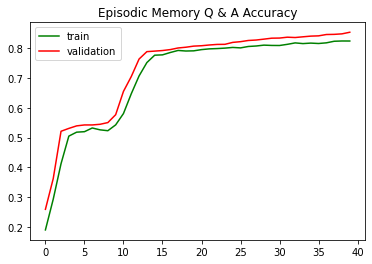

In [14]:
# 정확도와 손실도 플롯
plt.title("Episodic Memory Q & A Accuracy")
plt.plot(history.history["accuracy"], color="g", label="train")
plt.plot(history.history["val_accuracy"], color="r", label="validation")
plt.legend(loc="best")

plt.show()

In [15]:
# 레이블 예측 가져오기
ytest = np.argmax(Ytest, axis=1)
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [16]:
# 무작위로 질문을 선택하고 답변을 예측
NUM_DISPLAY = 10
for i in random.sample(range(Xstest.shape[0]),NUM_DISPLAY):
    story = " ".join([indx2word[x] for x in Xstest[i].tolist() if x != 0])
    question = " ".join([indx2word[x] for x in Xqtest[i].tolist()])
    label = indx2word[ytest[i]]
    prediction = indx2word[ytest_[i]]
    
    print(story, question, label, prediction)

sandra moved to the hallway . sandra journeyed to the office . where is sandra ? office office
john went back to the bedroom . mary went to the garden . where is mary ? garden garden
john travelled to the bedroom . daniel went to the hallway . where is sandra ? garden garden
john went to the garden . sandra travelled to the bathroom . where is john ? garden garden
sandra went to the bedroom . john went to the garden . where is mary ? bedroom kitchen
mary went back to the hallway . sandra went back to the hallway . where is mary ? hallway hallway
daniel moved to the hallway . sandra travelled to the bedroom . where is sandra ? bedroom bedroom
daniel moved to the kitchen . mary went back to the office . where is mary ? office office
mary went back to the bathroom . daniel moved to the office . where is mary ? bathroom bathroom
mary went back to the hallway . daniel travelled to the kitchen . where is daniel ? kitchen kitchen
